<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/avocado_waymo/tutorial/1_transformer/gp-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습
참고 : [Attention is All You Need Tutorial(ndb796)](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb)

자연어처리 끝판왕. 다른 분야에도 고르게 사용됨.

In [1]:
# 아,,, colab에서 UTF-8 오류 뜨는데 아래 코드로 해결함,,, 찝찝,,,,하네
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## 🔸Dataset

### 자연어를 어떻게 Input으로 줄 수 있을까?

기본적으로 모델의 INPUT은 숫자 형태로 들어가기 때문에 처리하고자 하는 문장을 분해 및 숫자로 변환하는 전처리 작업이 필요하다. 이 과정을 문장의 토큰화(tokenization)이라고 한다.

**torchtext**는 자연어처리에 유용한 라이브러리로, 데이터셋과 전처리 클래스, 스코어링 함수 등이 존재한다. 설치해보자!

In [2]:
%%capture
!pip install torchtext==0.6.0

### 데이터셋 전처리

이번에는 **spaCy** 라이브러리를 이용해보자. **토큰화(tokenization), 태깅(tagging) 등의 전처리**를 위한 라이브러리다. 영어와 한국어 전처리 모듈을 설치하고 확인해보자

In [3]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download ko_core_news_sm

In [4]:
import spacy

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_ko = spacy.load('ko_core_news_sm') # 한국어 토큰화(tokenization)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# 간단히 토큰화(tokenization) 기능 써보기
_tmp_en_tokens = spacy_en.tokenizer("I graduated last week.")
_tmp_ko_tokens = spacy_ko.tokenizer("저는 저번 주에 졸업했습니다.")

# 영어 문장 토큰화
for i, token in enumerate(_tmp_en_tokens):
    print(f"인덱스 {i}: {token.text}")

print("--------------")

# 한국어 문장 토큰화
for i, token in enumerate(_tmp_ko_tokens):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: graduated
인덱스 2: last
인덱스 3: week
인덱스 4: .
--------------
인덱스 0: 저는
인덱스 1: 저번
인덱스 2: 주에
인덱스 3: 졸업했습니다
인덱스 4: .


토큰화 과정을 함수화 해보자

In [6]:
tokenizer_en = lambda text: [token.text for token in spacy_en.tokenizer(text)]
tokenizer_ko = lambda text: [token.text for token in spacy_ko.tokenizer(text)]

In [7]:
tokenizer_en('I graduated last week.')

['I', 'graduated', 'last', 'week', '.']

필드(field)를 이용해 데이터셋에 대한 구체적인 전처리 과정을 명시할 수 있다. 이 작업을 통해 추후 코드에서 전처리를 조금 더 단순하게 다룰 수 있다.

In [8]:
from torchtext.data import Field

# 목표 : ko -> en 로 번역
src_field = Field(tokenize=tokenizer_ko, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
trg_field = Field(tokenize=tokenizer_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

**Parameter**
- tokenize : 어떤 토큰화 함수를 적용할 것인지 지정(default : split)
- init_token : ?
- eos_token : ?
- lower : 대문자가 있다면 소문자로 변경할 것인지
- batch_first : ?(미니배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지)

### 데이터셋 로드

이제 데이터셋을 불러오자. **torchtext의 datasets**에는 대표적인 번역 데이터셋인 **Mullti30k**이 있다. 였는데,,, 아쉽게도 한국어는 없어서 다른 라이브러리를 사용함.

여러 데이터셋을 모아서 라이브러리화 하는 **Korpora**라는 라이브러리가 있었음

In [9]:
%%capture
!pip install Korpora

In [10]:
from Korpora import Korpora
Korpora.fetch("korean_parallel_koen_news")
datasets = Korpora.load("korean_parallel_koen_news")

[korean_parallel] download korean-english-park.train.tar.gz: 8.72MB [00:00, 61.0MB/s]                            


decompress /root/Korpora/korean_parallel/korean-english-park.train.tar.gz


[korean_parallel] download korean-english-park.dev.tar.gz: 115kB [00:00, 1.79MB/s]


decompress /root/Korpora/korean_parallel/korean-english-park.dev.tar.gz


[korean_parallel] download korean-english-park.test.tar.gz: 238kB [00:00, 3.59MB/s]


decompress /root/Korpora/korean_parallel/korean-english-park.test.tar.gz

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/jungyeul/korean-parallel-corpora
    References :
        - Jungyeul Park, Jeen-Pyo Hong and Jeong-Won Cha (2016) Korean Language Resources for Everyone.
          In Proceedings of the 30th Pacific Asia Conference on Language, Information and Computation
          (PACLIC 30). October 28 - 30, 2016. Seoul, Korea. 
          (https://www.aclweb.org/anthology/Y16-2002/)

    # License
    Creative Commons Attribution Noncommercial No-Derivative-Works 3.0
    Details in https://creativecommons.org/licenses/by-nc-nd/3.0/



In [11]:
datasets.train

koennews.train: size=94123
  - koennews.train.texts : list[str]
  - koennews.train.pairs : list[str]

In [12]:
datasets.test

koennews.test: size=2000
  - koennews.test.texts : list[str]
  - koennews.test.pairs : list[str]

불러온 데이터셋을 예제를 따라가기 편한 구조로 변경해주었다. 기존의 `torchtext.datasets.translation.Multi30k` 구조가 `torchtext.data.Example`의 집합을 `torchtext.data.Dataset`으로 묶어준 형태여서 이것을 그대로 재현했다.

In [13]:
from torchtext.data import Example

test_dataset_examples = []

for text, pair in zip(datasets.test.texts, datasets.test.pairs):
  example = Example.fromlist([text, pair], [("src", src_field), ("trg", trg_field)])
  test_dataset_examples.append(example)

train_dataset_examples = []

for text, pair in zip(datasets.train.texts, datasets.train.pairs):
  example = Example.fromlist([text, pair], [("src", src_field), ("trg", trg_field)])
  train_dataset_examples.append(example)

In [14]:
# 데이터셋이 너무 많아서 학습이 오래걸림. 좀 줄이자,,,
import random

train_dataset_examples = random.sample(train_dataset_examples, k=50000)

In [15]:
from torchtext.data import Dataset

train_dataset = Dataset(examples=train_dataset_examples, fields=[("src", src_field), ("trg", trg_field)])
test_dataset  = Dataset(examples=test_dataset_examples,  fields=[("src", src_field), ("trg", trg_field)])

In [16]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['칼렌', '교수는', '이는', '나태할수록', '더', '많은', '돈을', '내야', '하는', '계약이라고', '밝혔다', '.', '그는', '개인적으로', '체중', '감량이나', '유지를', '위해', '벌금', '50달러', '(', '약', '6만5000원', ')', '을', '걸었다', '.']
['"', 'it', "'s", 'a', 'contract', 'to', 'make', 'slothfulness', 'more', 'expensive', ',', '"', 'said', 'karlan', ',', 'who', 'has', 'personally', 'put', 'up', 'to', '$', '50,000', 'at', 'stake', 'to', 'help', 'himself', 'lose', 'or', 'maintain', 'his', 'weight', '.']


이렇게 토큰화된 dataset을 구비했다. 이제 각 단어를 숫자 형태로 변경해주어야 한다. **Field**의 **build_vocab** 메서드를 이용해 사전을 만들 수 있고, 이를 기반으로 숫자로 변경한다.

In [17]:
src_field.build_vocab(train_dataset, min_freq=2)
trg_field.build_vocab(train_dataset, min_freq=2)

print(f"src vocab len : {len(src_field.vocab)}")
print(f"trg vocab len : {len(trg_field.vocab)}")

src vocab len : 59113
trg vocab len : 24337


**Parameter**
- min_freq : 최소 2번 이상 등장한 단어

In [18]:
trg_field.vocab.itos[4]

'the'

In [19]:
print(trg_field.vocab.stoi["hihihihi"]) # 없는 단어: 0
print(trg_field.vocab.stoi[trg_field.pad_token]) # 패딩(padding): 1
print(trg_field.vocab.stoi["<sos>"]) # : 2
print(trg_field.vocab.stoi["<eos>"]) # : 3
print(trg_field.vocab.stoi["a"])
print(trg_field.vocab.stoi["world"])

0
1
2
3
9
91


vocab 내에서 각 데이터를 숫자로 변환할 수 있는 것을 확인할 수 있었다. 그러나 각 문장 내 단어의 개수가 각기 다르기 때문에 BucketIterator를 이용하여 패딩을 포함한 동일한 개수로 맞춰줄 수 있다.
- 배치 크기(batch size): 128

In [20]:
import torch
from torchtext.data import BucketIterator

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device, sort=False)

In [21]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 54])
인덱스 0: 2
인덱스 1: 41241
인덱스 2: 1114
인덱스 3: 9310
인덱스 4: 51
인덱스 5: 6
인덱스 6: 261
인덱스 7: 4912
인덱스 8: 13381
인덱스 9: 252
인덱스 10: 1666
인덱스 11: 7199
인덱스 12: 247
인덱스 13: 1344
인덱스 14: 816
인덱스 15: 36
인덱스 16: 195
인덱스 17: 16141
인덱스 18: 35
인덱스 19: 13459
인덱스 20: 93
인덱스 21: 7
인덱스 22: 12
인덱스 23: 14
인덱스 24: 4
인덱스 25: 3
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1
인덱스 35: 1
인덱스 36: 1
인덱스 37: 1
인덱스 38: 1
인덱스 39: 1
인덱스 40: 1
인덱스 41: 1
인덱스 42: 1
인덱스 43: 1
인덱스 44: 1
인덱스 45: 1
인덱스 46: 1
인덱스 47: 1
인덱스 48: 1
인덱스 49: 1
인덱스 50: 1
인덱스 51: 1
인덱스 52: 1
인덱스 53: 1


## 🔸Transformer 모델 만들기

### Multi Head Attention 아키텍처

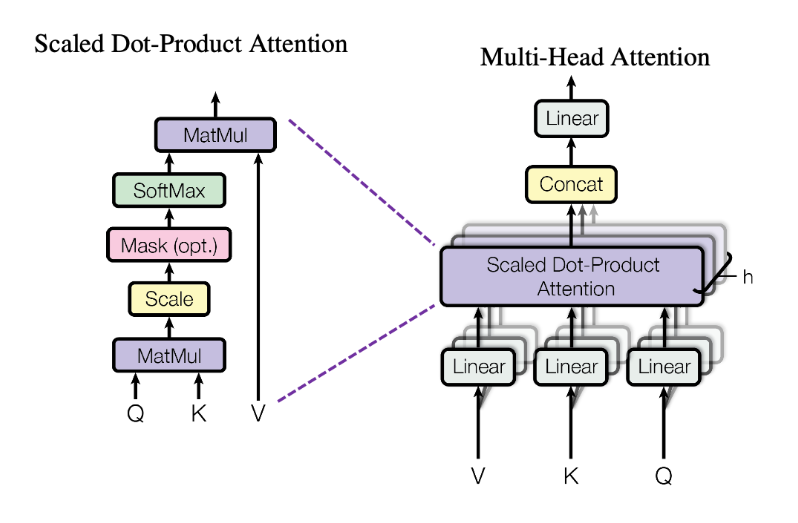
- Attention은 **Query, Key, Value**를 입력는다. 

In [22]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device=device):
    '''
    [hyberparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_heads       : 헤드(head)의 개수
      - dropout_ratio : dropout 비율
    '''
    super().__init__()

    assert hidden_dim % n_heads == 0
    
    self.hidden_dim = hidden_dim # 임베딩 차원
    self.n_heads    = n_heads    # 헤드(각 attention)의 개수
    self.head_dim   = hidden_dim // n_heads # 각 헤드에서의 임베딩 차원

    # Input FC
    self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query FC
    self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key FC
    self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value FC

    # Output FC
    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    # Dropout
    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
  
  def forward(self, query, key, value, mask = None):
    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # fc의 input/ouput의 차원이 같기 때문에 크기 변동 없음.
    # Q shape : [batch_size, query_len, hidden_dim]
    # K shape : [batch_size, key_len,   hidden_dim]
    # V shape : [batch_size, value_len, hidden_dim]

    # hidden_dim -> 헤드 개수만큼 {(n_heads) x (head_dim)} 형태로 변형
    #     .view()     ==> .reshape 같은 느낌
    #     .permute()  ==> 차원 순서 변경(?)
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # Q shape : [batch_size, n_heads, query_len, head_dim]
    # K shape : [batch_size, n_heads, key_len,   head_dim]
    # V shape : [batch_size, n_heads, value_len, head_dim]

    # Attention Energy 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    # energy shape : [batch_size, n_heads, query_len, key_len]
    
    # mask를 사용하는 경우
    if mask is not None:
      # mask 값이 0인 부분의 energy 값을 매우 작게 만들어주기
      energy = energy.masked_fill(mask==0, -1e10)

    # attention score
    attention = torch.softmax(energy, dim=-1) # 확률값

    # attention shape (변동없음) : [batch_size, n_heads, query_len, key_len]

    # Scaled Dot-Product Attention 계산
    x = torch.matmul(self.dropout(attention), V)

    # x shape : [batch_size, n_heads, query_len, head_dim]

    # .contiguous() : 축 변경은 해당되는 정보만 변경되고, 메모리 상에서의
    #                 구조가 바뀌지 않음. 근데 두 번 이상 변경하면 문제 발생.
    #                 복제하는 방식으로 해결해 주는 듯.
    x = x.permute(0, 2, 1, 3).contiguous()

    # x shape : [batch_size, query_len, n_heads, head_dim]

    x = x.view(batch_size, -1, self.hidden_dim)

    # x shape : [batch_size, query_len, hidden_dim]

    x = self.fc_o(x)

    # x shape : [batch_size, query_len, hidden_dim]

    return x, attention

    

한줄평 : 흐름은 이해가 됐는데, 차원 변환이 이해가 안된다,,,

### Position-wise Feedforward 아키텍처


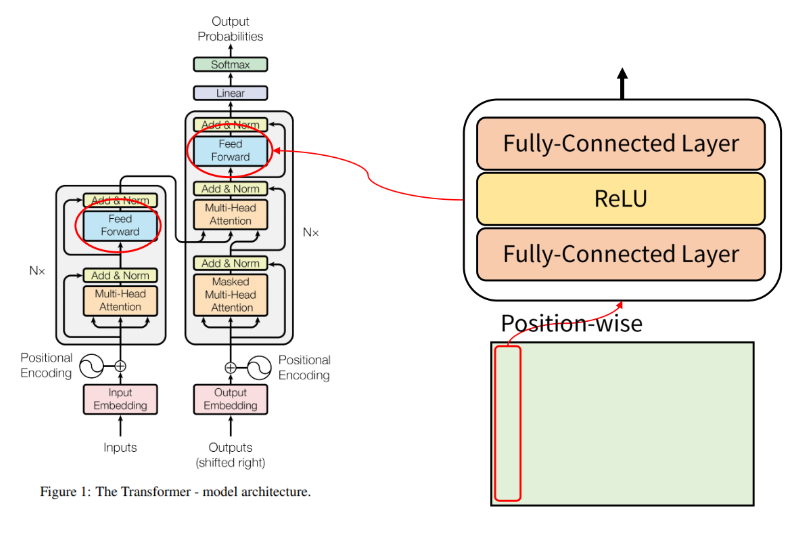

- Encoder 내부는 두개의 로직으로 이루어져있다. 위 사진은 Encoder 부분만 잘라낸 것이며, Multi-Head Attention을 거친 다음 진행되는 파란색 Feed Forward 로직이 이번 블록에서 작업할 **Position-wise Feedforward** 아키텍처다.
- FF 앞에 Position-wise가 붇는 이유는 Multi-Head Attention의 output이 각 단어(position)에 대한 정보이기 때문에 각 position에 대해 적용되는 FF라고 보면 된다. 

- 입력과 출력 차원이 동일하다

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
    '''
    [hyperparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - pf_dim        : feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
    '''
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, x):

    # x shape : [batch_size, seq_len, hidden_dim]

    x = self.dropout(torch.relu(self.fc_1(x)))

    # x shape : [batch_size, seq_len, pf_dim]

    x = self.fc_2(x)

    # x shape : [batch_size, seq_len, hidden_dim]
    
    return x

### Encoder Layer 아키텍처


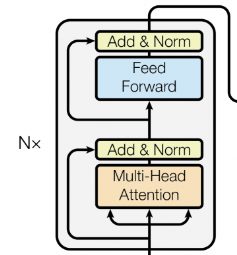
- Transformer는 Encoder를 여러번 중첩해서 사용한다.
  - Encoder 그림 좌측에 있는 **Nx**가 이를 뜻함. N번 반복한다.
- 그렇게 사용하기 위해서는 입력과 출력의 차원이 같아야 한다.


In [24]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    '''
    [hyperparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_heads       : 헤드(head)의 개수 = scaled dot-product attention의 개수
      - pf_dim        : Feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
    '''
    super().__init__()
    
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.self_attention_norm = nn.LayerNorm(hidden_dim)

    self.position_wise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.position_wise_feedforward_norm = nn.LayerNorm(hidden_dim)
    
    self.dropout = nn.Dropout(dropout_ratio)
    
  def forward(self, src, src_mask):

    # src shape      : [batch_size, src_len, hidden_dim]
    # src_mask shape : [batch_size, src_len]
    
    # self attention
    #   Option. 필요한 경우 mask 행렬을 이용하여 attention할 단어를 조절 가능
    _src, _ = self.self_attention(src, src, src, src_mask)

    # Multi-Head Attention 직후에 오는 'Add & Norm' 부분 구현
    #   - residual 한 구조를 띔(빠른 수렴).
    src = self.self_attention_norm(src + self.dropout(_src))

    # src shape : [batch_size, src_len, hidden_dim]

    # position-wise feedforward
    _src = self.position_wise_feedforward(src)

    # 마찬가지로 'Add & Norm'.
    src = self.position_wise_feedforward_norm(src + self.dropout(_src))

    return src



### Encoder 아키텍처


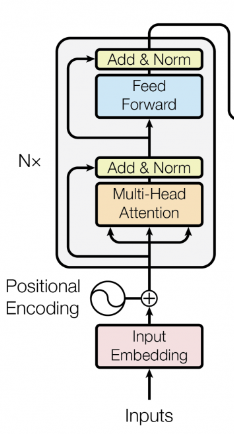
- 드디어 Encoder. Embedding 후 Encoder Layer를 중첩시키면 된다.
- 원본 논문에서는 positional embedding을 sin/cos 함수를 사용했는데, 여기서는 학습하는 형태로 구현.
  - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식
  

In [25]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
    '''
    [hyperparameter]
      - input_dim     : 하나의 단어에 대한 원 핫 인코딩 차원
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_layers      : 내부적으로 사용할 인코더 레이어의 개수 (Nx)
      - n_heads       : 헤드(head)의 개수 = scaled dot-product attention의 개수
      - pf_dim        : Feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
      - max_length    : 문장 내 최대 단어 개수
    '''
    super().__init__()

    self.device = device

    self.token_embedding    = nn.Embedding(input_dim, hidden_dim)
    self.position_embedding = nn.Embedding(max_length, hidden_dim)

    self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):

      # src: [batch_size, src_len]
      # src_mask: [batch_size, src_len]

      batch_size = src.shape[0]
      src_len    = src.shape[1]

      # positional encoding
      pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

      # pos: [batch_size, src_len]

      # input embedding 값과 position embedding을 더해서 최종 input 형성
      src = self.dropout((self.token_embedding(src) * self.scale) + self.position_embedding(pos))

      # src: [batch_size, src_len, hidden_dim]

      # encoder layer를 순차적으로 거침
      for layer in self.encoder_layers:
        src = layer(src, src_mask)

      return src # 마지막 레이어의 출력 반환



### Decoder Layer 아키텍처


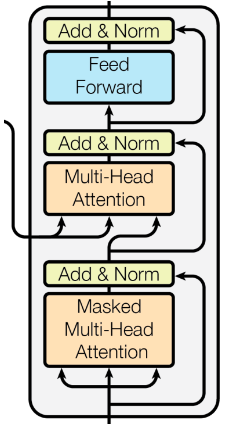
- Encoder Layer와 마찬가지로 입/출력 차원이 같고, 여러번 중첩해서 사용.
- 두 개의 Multi-Head Attention 레이어가 사용됨.


In [26]:
class DecoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    '''
    [hyperparameter]
      - hidden_dim: 하나의 단어에 대한 임베딩 차원
      - n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
      - pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio
    '''
    super().__init__()

    self.self_attention      = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.self_attention_norm = nn.LayerNorm(hidden_dim)

    self.encoder_attention      = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.encoder_attention_norm = nn.LayerNorm(hidden_dim)

    self.feed_forward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.feed_forward_norm = nn.LayerNorm(hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    # trg shape      : [batch_size, trg_len, hidden_dim]
    # enc_src shape  : [batch_size, src_len, hidden_dim]
    # trg_mask shape : [batch_size, trg_len]
    # src_mask shape : [batch_size, src_len]

    # 디코딩 결과에 대해서 self attention
    _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
    trg     = self.self_attention_norm(trg + self.dropout(_trg))

    # trg shape : [batch_size, trg_len, hidden_dim]

    # 디코더의 Query를 이용하여 encoding 결과를 attention
    _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
    trg             = self.encoder_attention_norm(trg + self.dropout(_trg))

    # trg shape       : [batch_size, trg_len, hidden_dim]
    # attention shape : [batch_size, n_heads, trg_len, src_len]

    _trg = self.feed_forward(trg)
    trg = self.feed_forward_norm(trg + self.dropout(_trg))

    # trg: [batch_size, trg_len, hidden_dim]

    return trg, attention


### Decoder 아키텍처

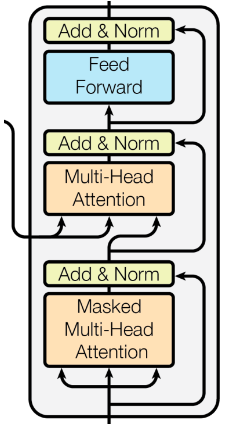
- Decoder Layer를 Nx만큼 쌓자 
- trg 문장에서 아직 예측하지 않은 단어는 mask를 통해 모델이 알 수 없도록 구성합니다. (치팅방지)


- (?) Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
  - 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.

In [27]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
    super().__init__()

    self.device = device

    self.token_embedding      = nn.Embedding(output_dim, hidden_dim)
    self.positional_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    self.dropout = nn.Dropout(dropout_ratio)
    
    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, trg, enc_src, trg_mask, src_mask):

    # trg shape      : [batch_size, trg_len]
    # enc_src shape  : [batch_size, src_len, hidden_dim]
    # trg_mask shape : [batch_size, trg_len]
    # src_mask shape : [batch_size, src_len]

    batch_size = trg.shape[0]
    trg_len    = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    # pos shape : [batch_size, trg_len]

    trg = self.dropout((self.token_embedding(trg) * self.scale) + self.positional_embedding(pos))

    # trg shape : [batch_size, trg_len, hidden_dim]

    for layer in self.layers:
      trg, attention = layer(trg, enc_src, trg_mask, src_mask)

    # trg shape : [batch_size, trg_len, hidden_dim]
    # attention: [batch_size, n_heads, trg_len, src_len]

    output = self.fc_out(trg)

    # output: [batch_size, trg_len, output_dim]

    return output, attention



### Transformer

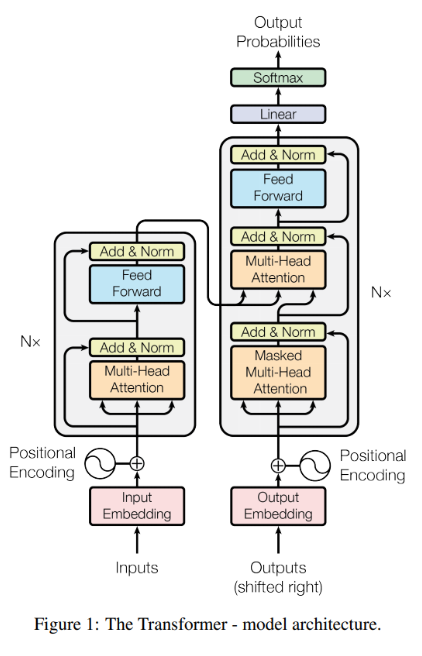
- 드디어 encoder, decoder를 합쳐서 Transformer를 구성해보자
- `<pad>` 토큰에 대해 mask 값을 0으로 설정.

In [28]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  # <pad> 토큰을 0으로 masking
  def make_src_mask(self, src):

    # src shape : [batch_size, src_len]

    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    # src_mask shape : [batch_size, 1, 1, src_len]

    return src_mask

  # 아직 예측하지 않은 단어는 masking
  def make_trg_mask(self, trg):

    # <pad> 마스킹 먼저 수행
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

    trg_len = trg.shape[1] # 한 문장의 길이

    # 한 문장에 대해 적용할 하삼각(tril) 형태의 mask 행렬 생성
    tril_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()


    # 최종 마스크 계산
    trg_mask = trg_pad_mask & tril_mask # 각 문장에 대해 tril_mask 적용
    
    # trg_mask shape : [batch_size, 1, trg_len, trg_len]

    return trg_mask

  def forward(self, src, trg):

    # src shape : [batch_size, src_len]
    # trg shape : [batch_size, trg_len]

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)

    # src_mask shape : [batch_size, 1, 1, src_len]
    # trg_mask shape : [batch_size, 1, trg_len, trg_len]

    context_vector = self.encoder(src, src_mask)

    # context_vector shape : [batch_size, src_len, hidden_dim]

    output, attention = self.decoder(trg, context_vector, trg_mask, src_mask)

    # output shape    : [batch_size, trg_len, output_dim]
    # attention shape : [batch_size, n_heads, trg_len, src_len]

    return output, attention


## 🔸학습 및 테스트

### 하이퍼파라미터 설정 및 초기화

In [29]:
INPUT_DIM = len(src_field.vocab)
OUTPUT_DIM = len(trg_field.vocab)
HIDDEN_DIM = 128 # 256
ENC_LAYERS = 2 # 3
DEC_LAYERS = 2 # 3
ENC_HEADS = 4 # 8
DEC_HEADS = 4 # 8
ENC_PF_DIM = 256 # 512
DEC_PF_DIM = 256 # 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [30]:
# <pad> masking을 위해 <pad>에 해당하는 숫자값 가져오기
SRC_PAD_IDX = src_field.vocab.stoi[src_field.pad_token]
TRG_PAD_IDX = trg_field.vocab.stoi[trg_field.pad_token]

- 모델 가중치 파라미터 초기화

In [31]:
# encoder와 decoder 객체 선언
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
decoder = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [32]:
num_of_param = 0

for param in model.parameters():
  if param.requires_grad:
    num_of_param += param.numel() # 파라미터 내 배열 원소의 개수

print(f'학습 가능한 파라미터 개수 : {num_of_param:,}')

학습 가능한 파라미터 개수 : 14,509,201


In [33]:
def initialize_weights(module):
  # weight가 존재하고, 2차원 이상의 서브모듈에 대해서만 적용  
  if hasattr(module, 'weight') and module.weight.dim() > 1:
    # transformer에서는 Xavier 초기화 방식이 잘 작동한다고 함.
    nn.init.xavier_uniform_(module.weight.data)

# apply : 모든 서브모듈에 대해 특정 함수 실행
model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (token_embedding): Embedding(59113, 128)
    (position_embedding): Embedding(100, 128)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (position_wise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=256, bias=True)
          (fc_2): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (position_wise_feedforward_norm): LayerNorm((128,), eps=

### 학습(training)

- 평가 함수 정의

In [34]:
# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 결과의 padding값은 무시
loss_func = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

- 학습 함수

In [35]:
def train(model, iterator, optimizer, loss_func, clip):
  model.train() # 학습모드
  epoch_loss = 0

  # 모든 데이터셋 순회
  for i, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg

    optimizer.zero_grad()

    # ??? trg의 eos를 없앤다고 하는데,,,
    # -1로 슬라이싱하면 <pad> 하나가 없어지는 것 뿐,,
    # 테스트 필요! 내 생각엔 슬라이싱 필요 없는듯?
    #output, _ = model(src, trg)
    output, _ = model(src, trg[:,:-1])

    # output: [배치 크기, trg_len - 1, output_dim]

    output_dim = output.shape[-1]

    # loss 계산을 위해 형태를 맞춰줌. (<sos>를 공통으로 제거)
    #     - model을 거친 결과(output)는 <sos> 가 없음. 정답지(target)에도 제거.
    output = output.contiguous().view(-1, output_dim) # ~~~ <eos><pad>
    target = trg[:,1:].contiguous().view(-1)          # ~~~ <eos><pad>

    # loss 계산 후 기울기를 계산
    loss = loss_func(output, target)
    loss.backward()

    # 기울기(gradient) clipping 진행
    #    : gradient가 너무 크면 학습이 잘 안돼서 기준치를 넘으면 자른다.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    # 옵티마이저를 사용하여 가중치 업데이트
    optimizer.step()

    # 모든 epoch 손실 값 합산 (평균 loss 구하기 위해서)
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)


- 모델 평가(evaluate) 함수

In [36]:
def evaluate(model, iterator, loss_func):
  model.eval() # 평가 모드
  epoch_loss = 0

  with torch.no_grad(): # 학습하지 않도록 설정
    for i, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg

      output, _ = model(src, trg[:,:-1]) # ???
      
      # 비교를 위해 형태 맞추기
      output_dim = output.shape[-1]
      output = output.contiguous().view(-1, output_dim)
      target = trg[:,1:].contiguous().view(-1) # <sos> 제거

      # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
      loss = loss_func(output, target)

      # 전체 손실 값 계산
      epoch_loss += loss.item()

    return epoch_loss / len(iterator)

- 학습(train) 및 검증(valid) 진행
  - 10 epoch

In [37]:
import time
import math
import random

NUM_OF_EPOCHS = 10
CLIP = 1 # 모든 파라미터 Norm 값이 1.0을 넘기면 gradient 스케일 조정
best_train_loss = float('inf')

for epoch in range(NUM_OF_EPOCHS):
  start_time = time.time() # 시작 시각

  train_loss = train(model, train_iterator, optimizer, loss_func, CLIP)

  exec_time = (time.time() - start_time) # 종료 시각(초)
  exec_min = int(exec_time / 60)
  exec_sec = int(exec_time - exec_min)

  if train_loss < best_train_loss:
    best_train_loss = train_loss
    torch.save(model.state_dict(), 'transformer.pt')

  print(f"Epoch: {epoch + 1:02} | Time: {exec_min}m {exec_sec}s")
  print(f"\t Train Loss : {train_loss:.3f} | PPL : {math.exp(train_loss):.3f}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-94d2ab04b88b>", line 12, in <module>
    train_loss = train(model, train_iterator, optimizer, loss_func, CLIP)
  File "<ipython-input-35-b3ccea4c24d8>", line 28, in train
    loss = loss_func(output, target)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py", line 1174, in forward
    return F.cross_entropy(input, target, weight=self.weight,
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py", line 3026, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
KeyboardInterrupt

During handling of the 

KeyboardInterrupt: ignored

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('transformer.pt')

### 테스트셋 검증

In [43]:
model.load_state_dict(torch.load('transformer.pt'))

test_loss = evaluate(model, test_iterator, loss_func)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 5.497 | Test PPL: 243.930


In [ ]:
# tutorial/1_transformer/gp-transformer.ipynb